In [ ]:
"""
visona-sentiment-analysis-prototype.ipynb
Jonathan Visona
CPSC 8985-02 - FA2024
"""

# utility imports
from string import punctuation
import os
import re
import warnings
#warnings.filterwarnings( 'ignore' )

# visualization imports
import matplotlib.pyplot as pyplt
import seaborn as sb 

# math and data science imports
import numpy as np 
    # https://pandas.pydata.org/docs/reference/frame.html
import pandas as pd 

# NLP imports
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

''''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"'\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
pd.set_option( 'display.max_columns', 20 )
pd.set_option( 'display.max_rows', 1_050_000 )

In [65]:
# This data is provided by Kaggle at https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset
training_data = pd.read_csv( '../data/train.csv', encoding='latin1' );
test_data = pd.read_csv( '../data/test.csv', encoding='latin1' );

In [69]:
df = pd.concat( [ training_data, test_data ] )
df2 = df.copy()
print( f"{type(df)=}, {len(df)=}" )

type(df)=<class 'pandas.core.frame.DataFrame'>, len(df)=32296


In [70]:
df.head( n=25 )

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,night,70-100,Antigua and Barbuda,97929.0,440.0,223.0
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,morning,0-20,Argentina,45195774.0,2736690.0,17.0
7,50e14c0bb8,Soooo high,Soooo high,neutral,noon,21-30,Armenia,2963243.0,28470.0,104.0
8,e050245fbd,Both of you,Both of you,neutral,night,31-45,Australia,25499884.0,7682300.0,3.0
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,morning,46-60,Austria,9006398.0,82400.0,109.0


In [71]:
# Provide general information on dataset
df.info( verbose=True )

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [72]:
# provide memory usage of columns
df.memory_usage()

Index               258368
textID              258368
text                258368
selected_text       258368
sentiment           258368
Time of Tweet       258368
Age of User         258368
Country             258368
Population -2020    258368
Land Area (Km²)     258368
Density (P/Km²)     258368
dtype: int64

In [73]:
# provide statistical description
df.describe()

,Population -2020,Land Area (Km²),Density (P/Km²)
count,3.101500e+04,3.101500e+04,31015.000000
mean,4.009768e+07,6.633212e+05,356.684733
std,1.500845e+08,1.811039e+06,2008.450729
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [ ]:
# clean up text to deal with links, non-alphanumerics, URLs, whitespace, etc.
def alphanumericize( txt: str ) -> str:
    txt = str( txt )
    try: 
        pattern_replacement_pairs = {
            r'<.*?>': '',
            r'[^a-zA-Z0-9\s]': '',
            #r'http?://\S+': ' ', # not sure if any value in SA
            #r'https?://\S+': ' ',
            r'\s+': ' '
        }
        for pattern, replacement in pattern_replacement_pairs.items():
            txt = re.sub( pattern, replacement, txt.strip() )
            #DEBUG print( f"{type(txt)=} {txt=}" )
        return txt
    except Exception as e:
        print( f"Error alphanumericizing: {e}" )
        return ""
    return 
df[ 'alphanumeric' ] = df[ 'text' ].apply( alphanumericize )
df2[ 'text' ] = df[ 'alphanumeric' ]

In [ ]:
def tokenize( txt:str ) -> list:
    try:
        return word_tokenize( str( txt ) )
    except Exception as e:
        print( f"Error tokenizing: {e}" )
        return ""
df[ 'tokens' ] = df[ 'text' ].apply( tokenize )

0        [I, `, d, have, responded, ,, if, I, were, going]
1        [Sooo, SAD, I, will, miss, you, here, in, San,...
2                        [my, boss, is, bullying, me, ...]
3                   [what, interview, !, leave, me, alone]
4        [Sons, of, *, *, *, *, ,, why, couldn, `, t, t...
5        [http, :, //www.dothebouncy.com/smf, -, some, ...
6        [2am, feedings, for, the, baby, are, fun, when...
7                                            [Soooo, high]
8                                          [Both, of, you]
9        [Journey, !, ?, Wow, ..., u, just, became, coo...
10       [as, much, as, i, love, to, be, hopeful, ,, i,...
11       [I, really, really, like, the, song, Love, Sto...
12       [My, Sharpie, is, running, DANGERously, low, o...
13       [i, want, to, go, to, music, tonight, but, i, ...
14                       [test, test, from, the, LG, enV2]
15                           [Uh, oh, ,, I, am, sunburned]
16       [S, `, ok, ,, trying, to, plot, alternatives, .

In [80]:
# convert to lowercase and remove redundant space around tokens
def normalize( txt: str ) -> str:
    txt = str( txt )
    try:
        txt = re.sub(r'[^\w\s]', '', txt.lower() )
        txt = re.sub(r'\s+', ' ', txt).strip()
    except Exception as e:
        print( f"Error normalizing: {e}" )
        return ""
    return txt 
df['normalized_text'] = df['text'].apply( normalize )

In [ ]:
# Remove stopwords provided by the nltk corpus
def remove_stopwords( text: str ) -> str:
    txt = str( txt )
    try:
        words = text.split()      
        filtered_words = [ word for word in words if word.lower() not in stopwords.words( 'english' ) ]
        filtered_text = ' '.join( filtered_words )
    except Exception as e:
        print( f"Error removing stopwords: {e}" )
        return ""
    return filtered_text
df[ 'text_without_stopwords' ] = df[ 'text' ].apply( remove_stopwords )

In [ ]:
# Solve gaps in data by dropping NaNs on current Dataframe
# Consider doing counts before and after
df.dropna( inplace=True )

<Axes: xlabel='sentiment'>

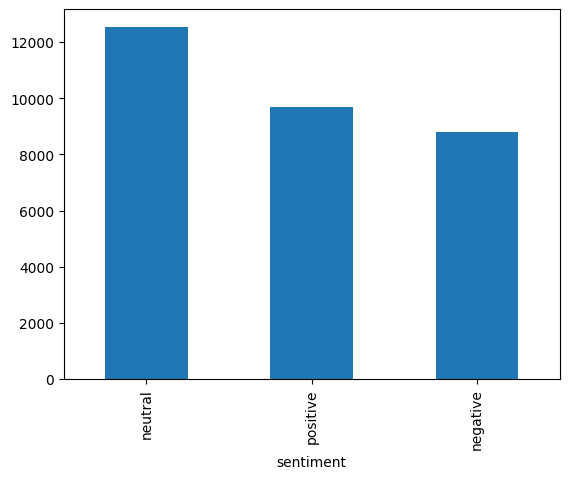

In [ ]:
 # Look at bar chart see counts as well as relative size
df[ 'sentiment' ].value_counts().plot( kind='bar' )

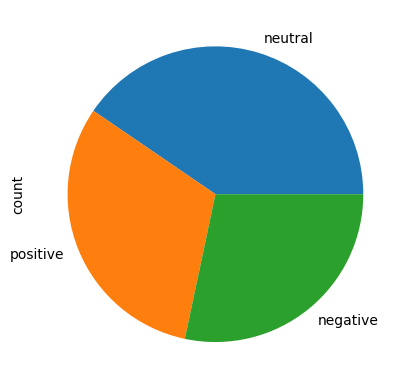

In [101]:
# Look at a pie graph to get relative size of three polarities
df[ 'sentiment' ].value_counts().plot( kind='pie' );

In [112]:
# Examine the tally of neutral, positive, and negative sentiments
df[ 'sentiment' ].value_counts()

sentiment
neutral     12548
positive     9685
negative     8782
Name: count, dtype: int64

In [ ]:
#
df[ 'sentiment_code' ] = df[ 'sentiment' ].astype( 'category' ).cat.codes
#sentiment_distribution = df[ 'sentiment_code '].value_counts()
#sentiment_distribution.plot( kind='bar' )
pyplt.show()

In [ ]:
stuff_to_be_removed = list( stopwords.words( 'english' ) ) + list( punctuation )
stemmer = LancasterStemmer()
text_list = df[ 'text' ].tolist()
print( len( text_list ) )
for each_txt
print(text_list[1] )

32296
 Sooo SAD I will miss you here in San Diego!!!


In [ ]:
# Show word frequency data
word_frq = FreqDist( word_tokenize( ' '.join(df[ 'sentiment' ] ) ) )
pyplt.figure( figsize=( 10, 6 ) )
word_frq.plot( 20, cumulative=False )
pyplt.title( 'Word Frequency Distribution' )
pyplt.xlabel( 'Word')
pyplt.ylabel( 'Frequency' )
pyplt.show()

TypeError: sequence item 31015: expected str instance, float found

In [122]:
final_corpus = df[ 'text' ].astype( str ).tolist()
data_eda = pd.DataFrame()
data_eda[ 'text' ] = final_corpus
data_eda[ 'sentiment' ] = df[ 'sentiment' ].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
# Why is this data even used?
df[ 'Time of Tweet' ] = df[ 'Time of Tweet' ].astype( 'category' ).cat.codes
df[ 'Country' ] = df[ 'Country' ].astype( 'category' ).cat.codes
df[ 'Age of User' ]=df[ 'Age of User' ].replace( {'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80} )

In [ ]:
# Should I drop this data earlier?
df=df.drop( columns=[ 'textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)' ] )

In [ ]:
import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)

In [ ]:
X = df[ 'selected_text' ]
Y = df[ 'sentiment' ]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42 )

In [ ]:
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform( X_train )
XV_test = vectorization.transform( X_test )

In [ ]:
score_baseline = df[ 'sentiment' ].value_counts( normalize=True ).max()
score_baseline

In [ ]:
lr = LogisticRegression( n_jobs=-1 )
lr.fit( XV_train,y_train )

In [ ]:
pred_lr = lr.predict( XV_test )

In [ ]:
score_lr = accuracy_score( y_test, pred_lr )
score_lr

In [ ]:
# not defined; prob sklern
print( classification_report( y_test, pred_lr ) )

NameError: name 'classification_report' is not defined

In [ ]:
ConfusionMatrixDisplay.from_predictions( y_test, pred_lr )

In [ ]:
#
dt = DecisionTreeClassifier()
dt.fit( XV_train, y_train )

In [ ]:
pred_dt = dt.predict(XV_test)

In [ ]:
score_dt = dt.score(XV_test, y_test)
score_dt

In [ ]:
print(classification_report(y_test, pred_dt))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_dt);

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(XV_train, y_train)

In [ ]:
pred_rfc = rfc.predict(XV_test)

In [ ]:
score_rfc = rfc.score(XV_test, y_test)
score_rfc

In [ ]:
#
print( classification_report( y_test, pred_rfc) )

In [ ]:
ConfusionMatrixDisplay.from_predictions( y_test, pred_rfc );

In [ ]:
print(f'Baseline model:{score_baseline} \nLogistic regression {score_lr}\nDecision Tree Classification {score_dt}\nRandim Forest Classifier {score_rfc}')

In [ ]:
def label_sentiment(n):
    if n==0:
        return "negative sentiment"
    elif n==1:
        return "neutral sentiment"
    elif n==2:
        return "positive sentiment"
    else:
        assert n > 3, "illegal sentiment classification"
    
def test_item( news ):
    testing_news = { "text": [ news ] }
    new_def_test = pd.DataFrame( testing_news )
    new_def_test["text"] = new_def_test[ "text" ].apply( wp ) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform( new_x_test )
    pred_lr = lr.predict( new_xv_test )
    pred_dt = dt.predict( new_xv_test )
    pred_rfc = rfc.predict( new_xv_test )

    return print( ( label_sentiment( pred_lr[1] ) ) )

In [ ]:
def to_upper( txt ):
    return txt.upper()
def test_item( news ):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame( testing_news )
    new_def_test[ "text" ] = new_def_test[ "text" ].apply( to_upper ) 
    new_x_test = new_def_test[ "text" ]
    new_xv_test = vectorization.transform(new_x_test)
    return new_xv_test
txt = "I am Sad"
test_item( txt )